In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Step 1: Data Cleaning
file_path = '/content/drive/MyDrive/Colab_Notebooks/project/anonymized_hubspot_companies.csv'
df = pd.read_csv(file_path, low_memory=False)

In [10]:
print("DataFrame Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())

duplicate_count = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_count)

print("\nFirst 5 Rows:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19851 entries, 0 to 19850
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Parent Company                31 non-null     object 
 1   CCaaS                         2086 non-null   object 
 2   Annual Revenue                18341 non-null  float64
 3   Target Account                33 non-null     object 
 4   Associated Contact            17792 non-null  object 
 5   Number of Form Submissions    17248 non-null  float64
 6   Total Agents                  0 non-null      float64
 7   Web Technologies              18607 non-null  object 
 8   Close Date                    71 non-null     object 
 9   # of Agents Total             42 non-null     float64
 10  Number of times contacted     11544 non-null  float64
 11  Contact with Primary Company  17248 non-null  object 
 12  ICP Fit Level                 5983 non-null 

In [11]:
threshold = 0.8
df = df.loc[:, df.isnull().mean() < threshold].copy()

zero_threshold = 0.8
num_columns = df.select_dtypes(include=[np.number]).columns
cols_to_drop = [col for col in num_columns if (df[col] == 0).mean() > zero_threshold]
df = df.drop(columns=cols_to_drop)

num_columns = df.select_dtypes(include=[np.number]).columns

cat_columns = df.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

for col in num_columns:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

print("DataFrame shape after cleaning:", df.shape)
print(df.info())

DataFrame shape after cleaning: (19851, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19851 entries, 0 to 19850
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Revenue                19851 non-null  float64
 1   Associated Contact            19851 non-null  object 
 2   Web Technologies              19851 non-null  object 
 3   Number of times contacted     19851 non-null  float64
 4   Contact with Primary Company  19851 non-null  object 
 5   ICP Fit Level                 19851 non-null  object 
 6   Record ID                     19851 non-null  int64  
 7   Time Zone                     19851 non-null  object 
 8   Primary Industry              19851 non-null  object 
 9   Year Founded                  19851 non-null  float64
 10  State/Region                  19851 non-null  object 
 11  Consolidated Industry         19851 non-null  object 
 12  Number of Employ

In [12]:
# Date Conversion
print(df[['Create Date', 'Last Modified Date']].head())

df['Create Date'] = pd.to_datetime(df['Create Date'], format='%Y-%m-%d %H:%M', errors='coerce')
df['Last Modified Date'] = pd.to_datetime(df['Last Modified Date'], format='%Y-%m-%d %H:%M', errors='coerce')

print(df[['Create Date', 'Last Modified Date']].head())
print(df.info())

        Create Date Last Modified Date
0  2024-10-30 10:51   2025-02-14 13:39
1  2024-09-12 18:30   2025-02-14 13:39
2  2024-09-03 10:44   2025-02-14 13:39
3  2024-08-02 11:36   2025-02-14 13:39
4  2024-08-02 11:36   2025-02-14 13:39
          Create Date  Last Modified Date
0 2024-10-30 10:51:00 2025-02-14 13:39:00
1 2024-09-12 18:30:00 2025-02-14 13:39:00
2 2024-09-03 10:44:00 2025-02-14 13:39:00
3 2024-08-02 11:36:00 2025-02-14 13:39:00
4 2024-08-02 11:36:00 2025-02-14 13:39:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19851 entries, 0 to 19850
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Annual Revenue                19851 non-null  float64       
 1   Associated Contact            19851 non-null  object        
 2   Web Technologies              19851 non-null  object        
 3   Number of times contacted     19851 non-null  float64       
 4   Cont

In [13]:
# Feature Engineering
df['duration'] = (df['Last Modified Date'] - df['Create Date']).dt.days

print("\n'duration' feature sample values:")
print(df['duration'].head())
print(df.info())


'duration' feature sample values:
0    107
1    154
2    164
3    196
4    196
Name: duration, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19851 entries, 0 to 19850
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Annual Revenue                19851 non-null  float64       
 1   Associated Contact            19851 non-null  object        
 2   Web Technologies              19851 non-null  object        
 3   Number of times contacted     19851 non-null  float64       
 4   Contact with Primary Company  19851 non-null  object        
 5   ICP Fit Level                 19851 non-null  object        
 6   Record ID                     19851 non-null  int64         
 7   Time Zone                     19851 non-null  object        
 8   Primary Industry              19851 non-null  object        
 9   Year Founded                  19851 non-null  float

In [14]:
# Outlier Handling
for col in num_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print(df.shape)
print(df.columns)

(19851, 20)
Index(['Annual Revenue', 'Associated Contact', 'Web Technologies',
       'Number of times contacted', 'Contact with Primary Company',
       'ICP Fit Level', 'Record ID', 'Time Zone', 'Primary Industry',
       'Year Founded', 'State/Region', 'Consolidated Industry',
       'Number of Employees', 'Primary Sub-Industry', 'Country/Region',
       'Industry', 'Create Date', 'Company name', 'Last Modified Date',
       'duration'],
      dtype='object')


In [15]:
df.drop(columns=["Record ID"], inplace=True)
num_columns = df.select_dtypes(include=[np.number]).columns

In [16]:
# Summary Statistics
numeric_stats = df[num_columns].describe().T
numeric_stats.rename(columns={'50%': 'median'}, inplace=True)

print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max) for Numeric Columns:")
print(numeric_stats[['mean', 'median', 'std', 'min', 'max']])


Summary Statistics (Mean, Median, Standard Deviation, Min, Max) for Numeric Columns:
                                   mean       median           std     min  \
Annual Revenue             5.665757e+08  100000000.0  8.554447e+08   225.0   
Number of times contacted  7.141857e+00          6.0  4.408776e+00     0.0   
Year Founded               1.975758e+03       1988.0  3.709490e+01  1890.5   
Number of Employees        3.899408e+03       2100.0  4.044602e+03     0.0   
duration                   5.315652e+02        517.0  2.308116e+02     0.0   

                                    max  
Annual Revenue             2.492218e+09  
Number of times contacted  1.500000e+01  
Year Founded               2.023000e+03  
Number of Employees        1.175000e+04  
duration                   9.270000e+02  


In [17]:
# Class distribution
for col in cat_columns:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())


Value counts for 'Associated Contact':
Associated Contact
Contact_71a916e7    2062
Contact_948fa4eb       3
Contact_c3835544       2
Contact_5e9a9d69       2
Contact_0f292d58       2
                    ... 
Contact_d122e2b9       1
Contact_27da830f       1
Contact_4f04000e       1
Contact_559feccb       1
Contact_eccd5031       1
Name: count, Length: 17684, dtype: int64

Value counts for 'Web Technologies':
Web Technologies
Microsoft Exchange Online; Microsoft Office 365; Godaddy Nameserver; Outlook                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [18]:
# correlation matrix
corr_matrix = df[num_columns].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)


Correlation Matrix:
                           Annual Revenue  Number of times contacted  \
Annual Revenue                   1.000000                   0.011126   
Number of times contacted        0.011126                   1.000000   
Year Founded                    -0.176964                  -0.066868   
Number of Employees              0.503482                   0.241573   
duration                        -0.106222                   0.356685   

                           Year Founded  Number of Employees  duration  
Annual Revenue                -0.176964             0.503482 -0.106222  
Number of times contacted     -0.066868             0.241573  0.356685  
Year Founded                   1.000000            -0.274724 -0.096005  
Number of Employees           -0.274724             1.000000  0.170054  
duration                      -0.096005             0.170054  1.000000  


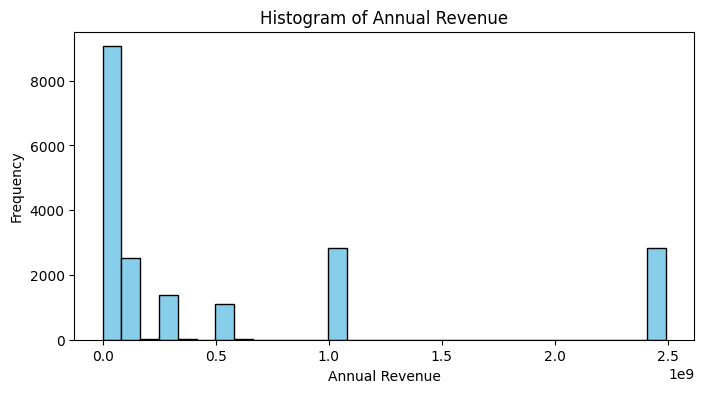

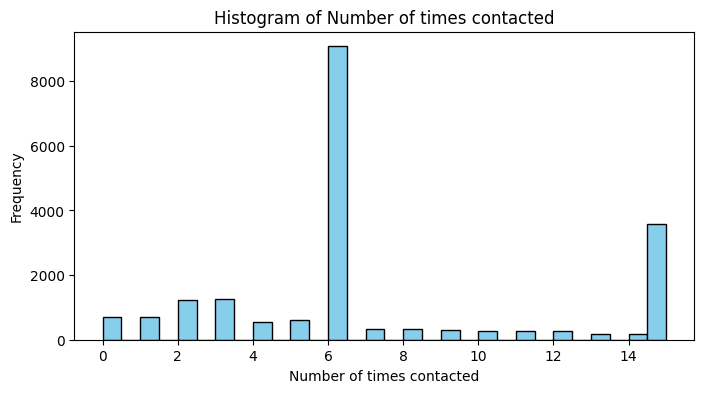

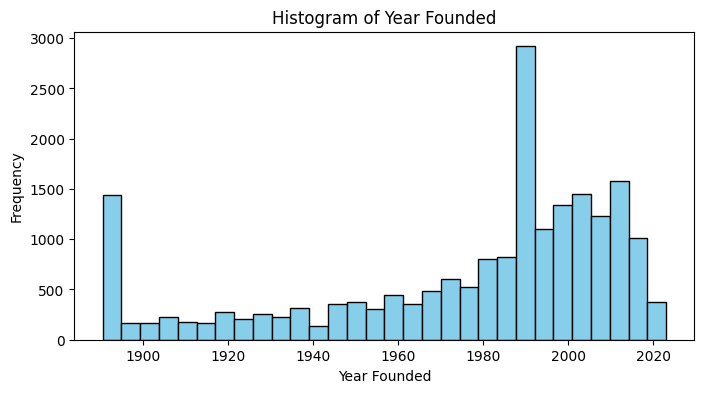

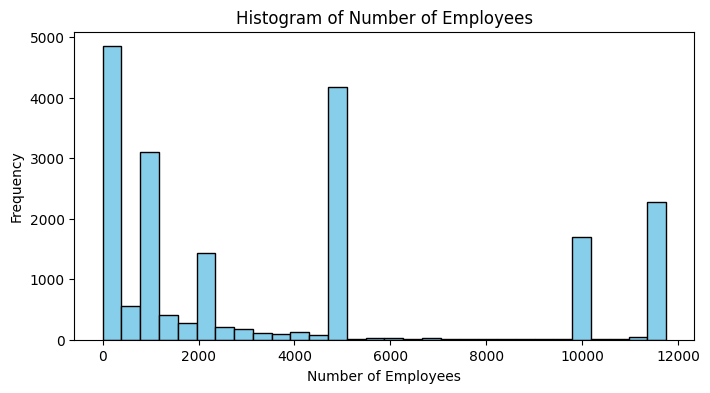

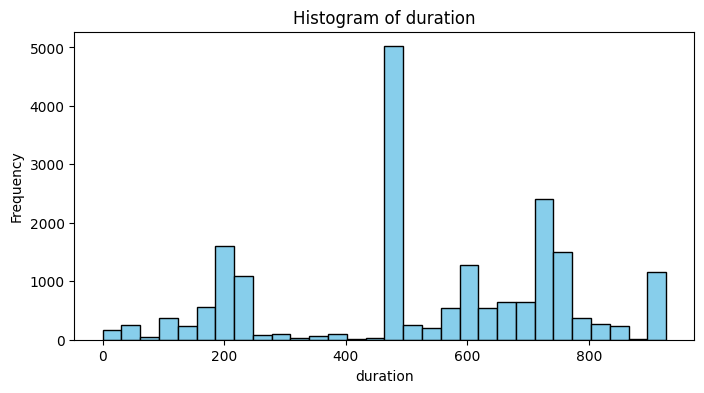

In [19]:
# Data Visualizations

# histograms
for col in num_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

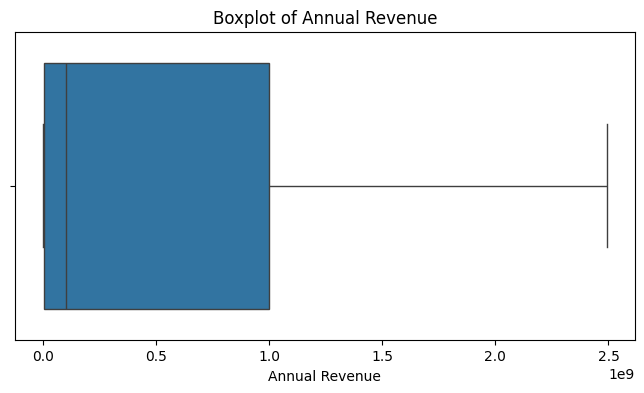

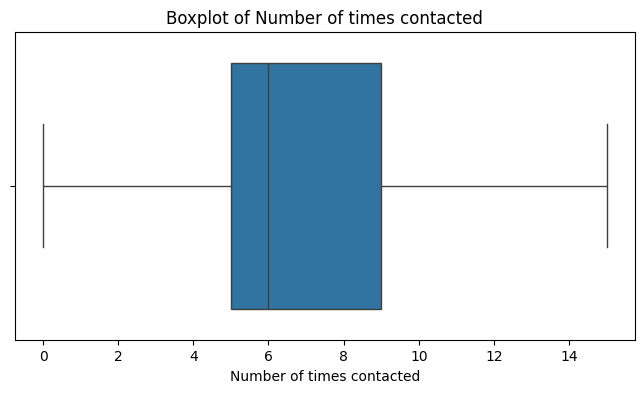

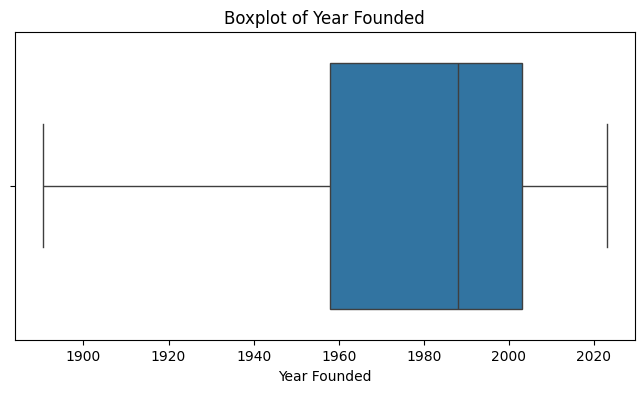

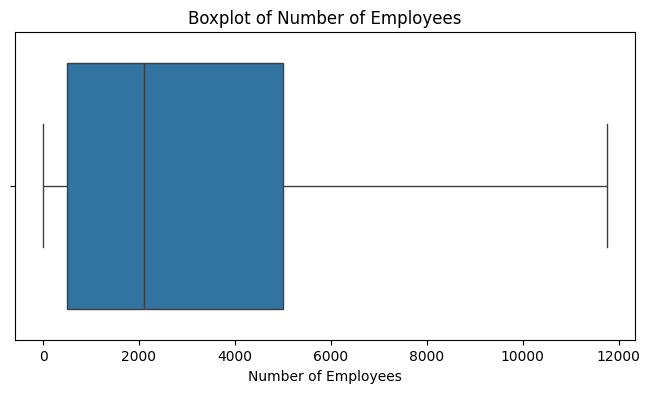

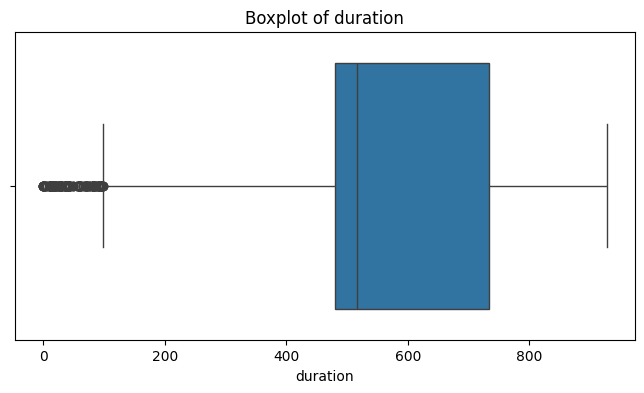

In [20]:
# box plots
for col in num_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


Column: Associated Contact
Associated Contact
Contact_71a916e7    10.387386
Contact_948fa4eb     0.015113
Contact_c3835544     0.010075
Contact_5e9a9d69     0.010075
Contact_0f292d58     0.010075
Contact_a63d6b30     0.010075
Contact_812645ab     0.010075
Contact_0372efb5     0.010075
Contact_475d3351     0.010075
Contact_b6ffc776     0.010075
Name: proportion, dtype: float64


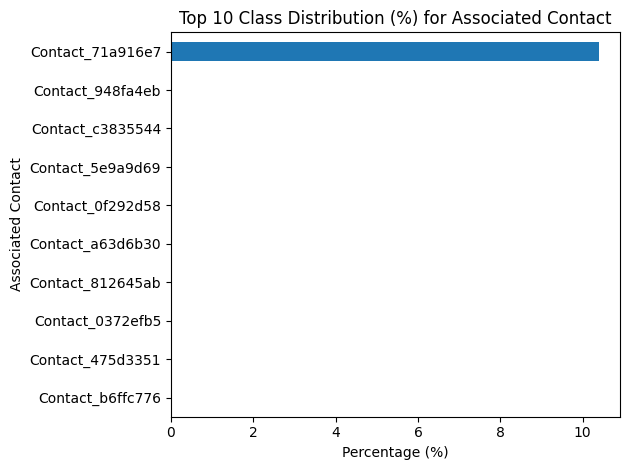


Column: Web Technologies
Web Technologies
Microsoft Exchange Online; Microsoft Office 365; Godaddy Nameserver; Outlook    6.543751
Microsoft Exchange Online; Salesforce; Microsoft Office 365; Outlook            0.251876
Microsoft Exchange Online; Microsoft Office 365; Outlook                        0.236764
Salesforce                                                                      0.206539
Google Apps                                                                     0.201501
Google Tag Manager                                                              0.161201
Google Analytics                                                                0.156163
Microsoft Exchange Online; Outlook                                              0.151126
Microsoft Exchange Online; Salesforce; Outlook                                  0.146088
Godaddy Nameserver; Google Apps                                                 0.136013
Name: proportion, dtype: float64


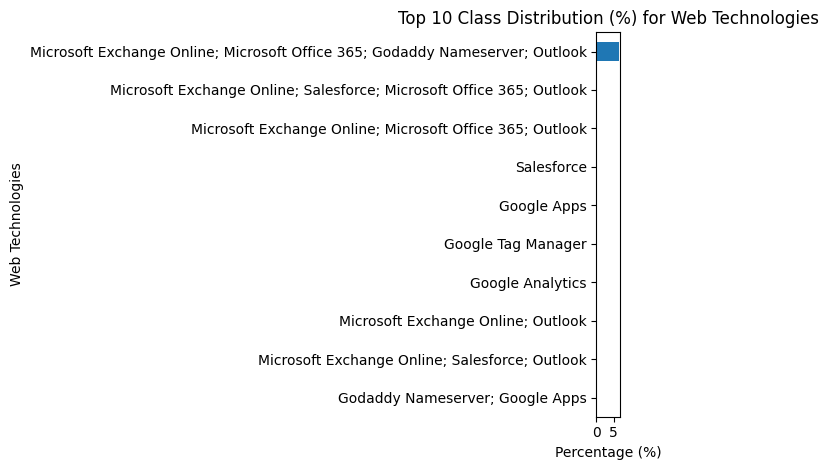


Column: Contact with Primary Company
Contact with Primary Company
Company_576068e6    13.122765
Company_7cdebdc1     0.010075
Company_48fdaa35     0.005038
Company_98422fde     0.005038
Company_4eea30f2     0.005038
Company_2453efb3     0.005038
Company_637c32a8     0.005038
Company_2cfa7562     0.005038
Company_4375cd8e     0.005038
Company_190ee4f6     0.005038
Name: proportion, dtype: float64


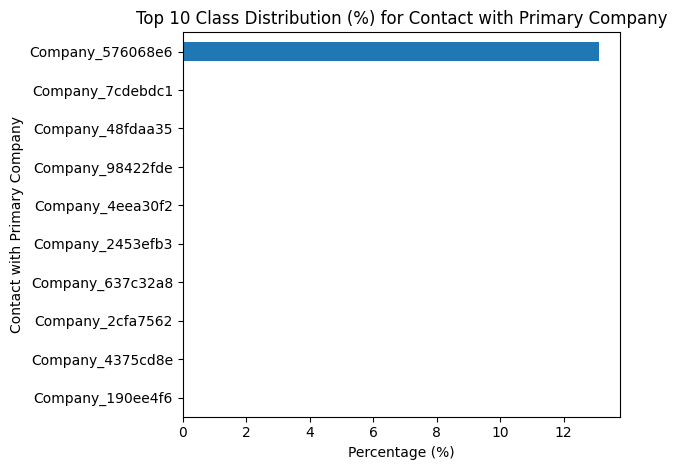


Column: ICP Fit Level
ICP Fit Level
Tier 2: Partial Fit    80.313334
Tier 3: Long Tail      10.357161
Tier 1: Ideal Fit       9.329505
Name: proportion, dtype: float64


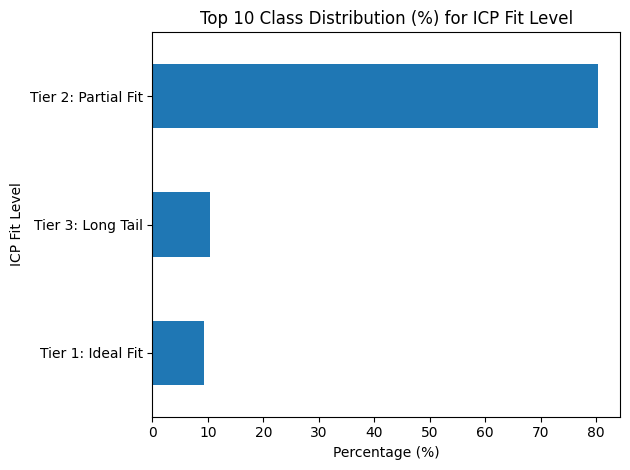


Column: Time Zone
Time Zone
America/New_York       38.874616
America/Chicago        19.077125
America/Los_Angeles    12.810438
America/Denver          3.037630
Europe/London           2.372676
America/Toronto         2.151025
Asia/Kolkata            2.025087
America/Detroit         1.627122
America/Phoenix         1.355095
Europe/Berlin           0.942018
Name: proportion, dtype: float64


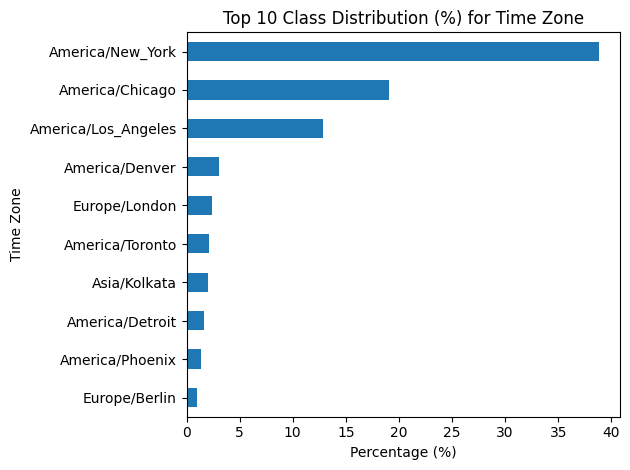


Column: Primary Industry
Primary Industry
Manufacturing                     53.856229
Business Services                  7.223817
Finance                            5.218881
Software                           4.478364
Education                          3.752960
Retail                             3.425520
Hospitals & Physicians Clinics     2.488540
Insurance                          2.423052
Transportation                     2.392827
Hospitality                        2.317264
Name: proportion, dtype: float64


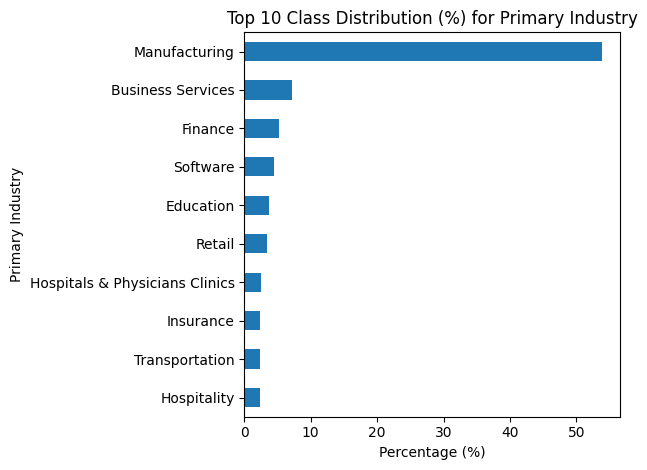


Column: State/Region
State/Region
California    11.586318
CA             4.251675
Texas          3.883935
New York       3.591759
Florida        2.755529
Illinois       2.448239
TX             2.428089
NY             2.312226
Ontario        2.287038
FL             2.221551
Name: proportion, dtype: float64


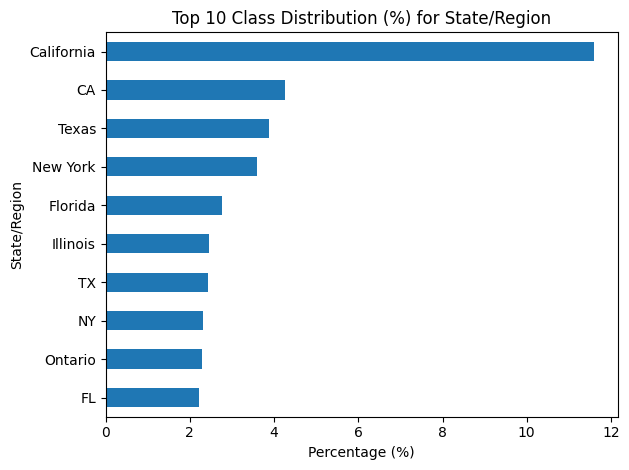


Column: Consolidated Industry
Consolidated Industry
(No value)                  10.473024
Healthcare                  10.165735
Banking                      9.682132
Technology                   9.586419
Consumer Goods               7.097879
BPO                          6.296912
Communications and Media     5.924135
Education                    5.455645
Insurance                    4.987154
Retail                       4.644602
Name: proportion, dtype: float64


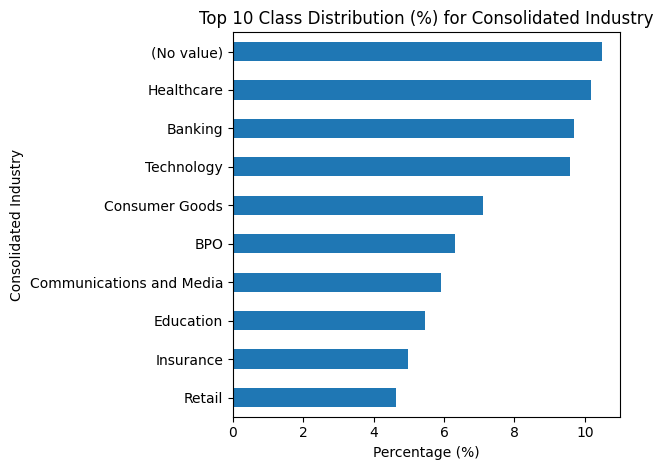


Column: Primary Sub-Industry
Primary Sub-Industry
Banking                             57.412725
Colleges & Universities              2.619515
Custom Software & IT Services        1.929374
Medical & Surgical Hospitals         1.380283
Industrial Machinery & Equipment     1.324870
Freight & Logistics Services         1.188857
Management Consulting                1.057881
Food & Beverage                      0.977281
Electricity, Oil & Gas               0.936981
Building Materials                   0.896680
Name: proportion, dtype: float64


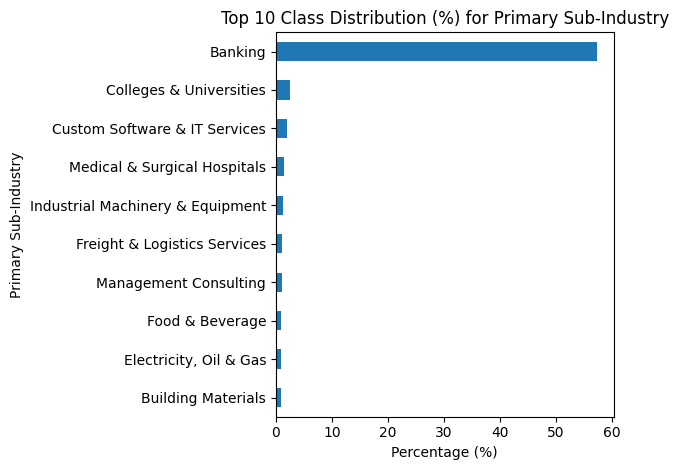


Column: Country/Region
Country/Region
United States     77.985996
Canada             4.669790
United Kingdom     2.367639
India              1.924336
Australia          1.138482
Germany            1.047806
France             0.957131
Japan              0.816080
Switzerland        0.639766
Singapore          0.438265
Name: proportion, dtype: float64


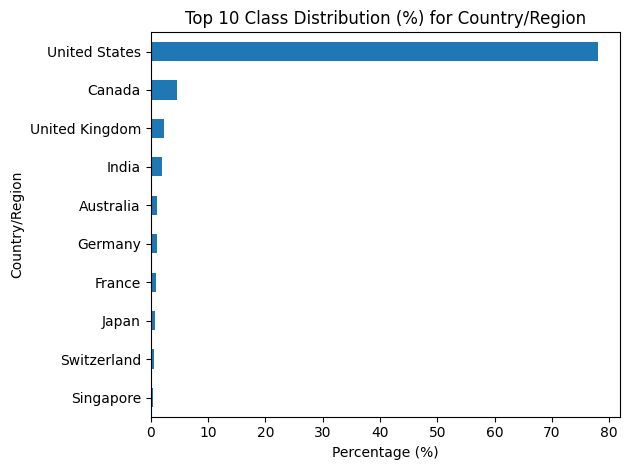


Column: Industry
Industry
Computer Software                   10.024684
Hospital & Health Care               6.029923
Insurance                            5.158430
Banking                              4.538814
Financial Services                   3.586721
Professional Training & Coaching     3.370107
Higher Education                     3.249207
Technology                           2.992293
Construction                         2.543952
Healthcare                           2.503652
Name: proportion, dtype: float64


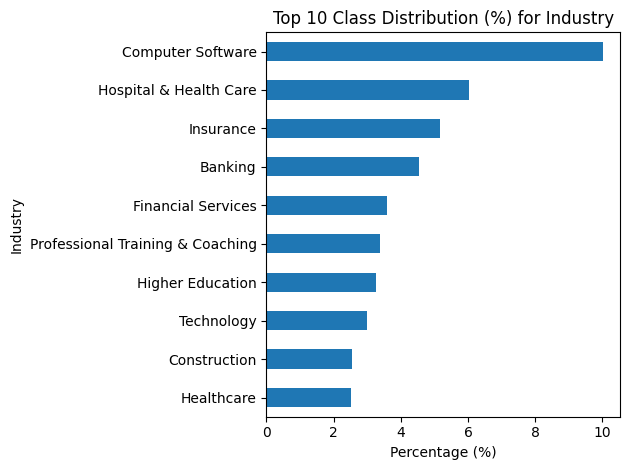


Column: Create Date
Create Date
2023-10-23 11:07:00    8.367337
2024-08-02 11:36:00    7.087804
2023-02-10 19:11:00    6.830890
2023-10-20 11:05:00    2.941917
2023-10-20 11:06:00    2.780716
2022-08-12 03:59:00    2.740416
2023-01-06 14:11:00    2.145988
2023-10-23 11:10:00    2.125837
2023-02-07 14:55:00    2.110725
2024-06-13 08:14:00    2.045237
Name: proportion, dtype: float64


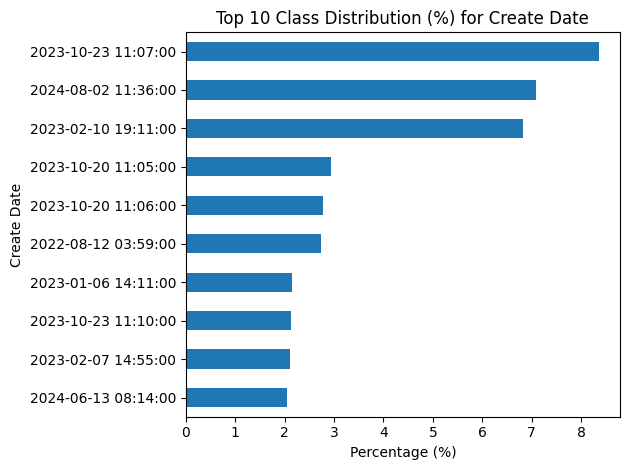


Column: Company name
Company name
Company_4305cea8    0.010075
Company_ee655b25    0.005038
Company_b76f1f65    0.005038
Company_69ad4524    0.005038
Company_88b1432e    0.005038
Company_e51ef244    0.005038
Company_7805b1f6    0.005038
Company_1d189654    0.005038
Company_6176f53c    0.005038
Company_5a9f87f8    0.005038
Name: proportion, dtype: float64


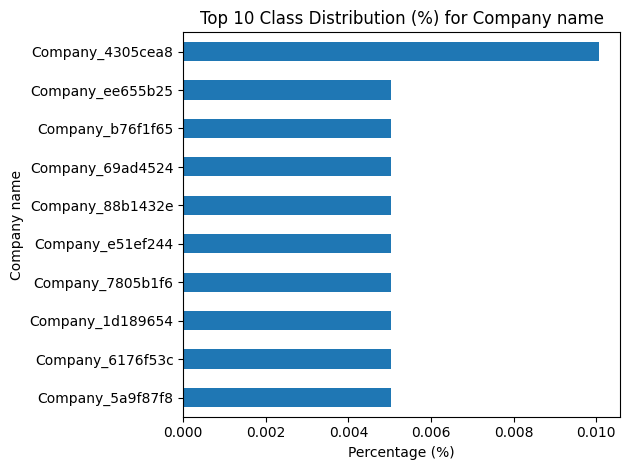


Column: Last Modified Date
Last Modified Date
2025-02-14 13:39:00    89.894716
2025-02-20 16:58:00     7.374943
2025-02-17 14:54:00     0.297214
2025-02-14 13:40:00     0.256914
2025-02-14 13:42:00     0.025188
2025-02-17 16:03:00     0.020150
2025-02-17 17:22:00     0.020150
2025-02-17 17:25:00     0.020150
2025-02-20 09:07:00     0.020150
2025-02-18 16:16:00     0.015113
Name: proportion, dtype: float64


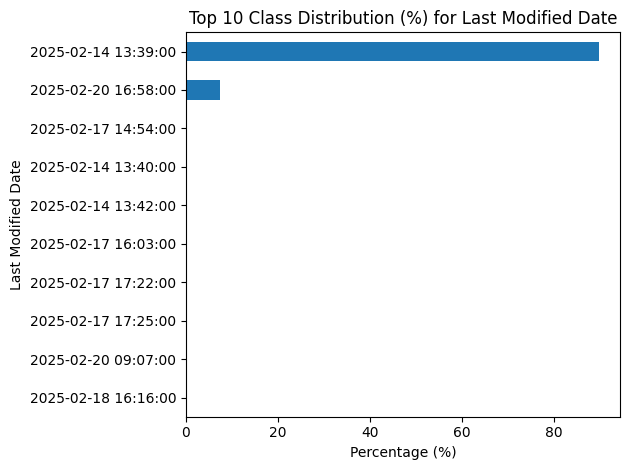

In [21]:
# Top 10 Class Distribution with Percentages for Categorical Features
for col in cat_columns:
    print(f"\nColumn: {col}")
    counts_percent = df[col].value_counts(normalize=True).head(10) * 100
    print(counts_percent)
    counts_percent.iloc[::-1].plot(kind='barh', title=f"Top 10 Class Distribution (%) for {col}")
    plt.xlabel("Percentage (%)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

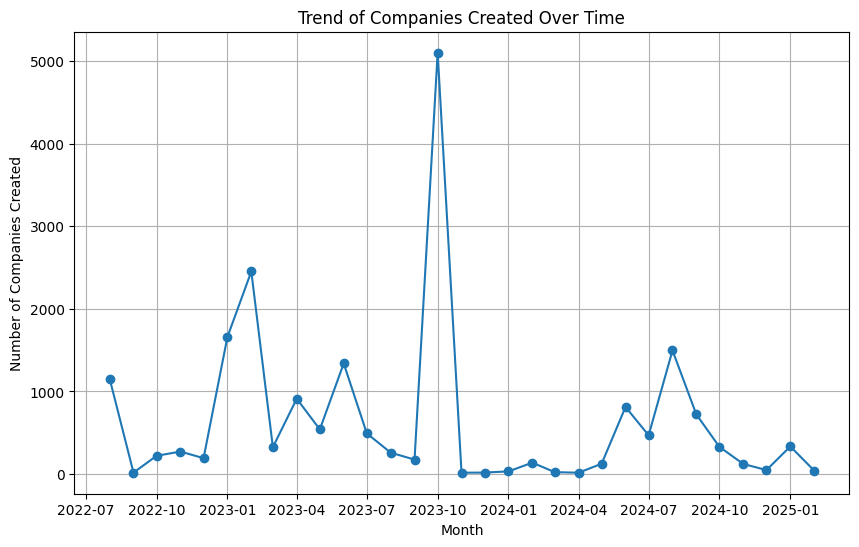

In [22]:
df['Create_Month'] = df['Create Date'].dt.to_period('M')

# time-series trends: Count the number of companies created per month
company_count = df.groupby('Create_Month').size()
company_count.index = company_count.index.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(company_count.index, company_count.values, marker='o')
plt.xlabel("Month")
plt.ylabel("Number of Companies Created")
plt.title("Trend of Companies Created Over Time")
plt.grid(True)
plt.show()

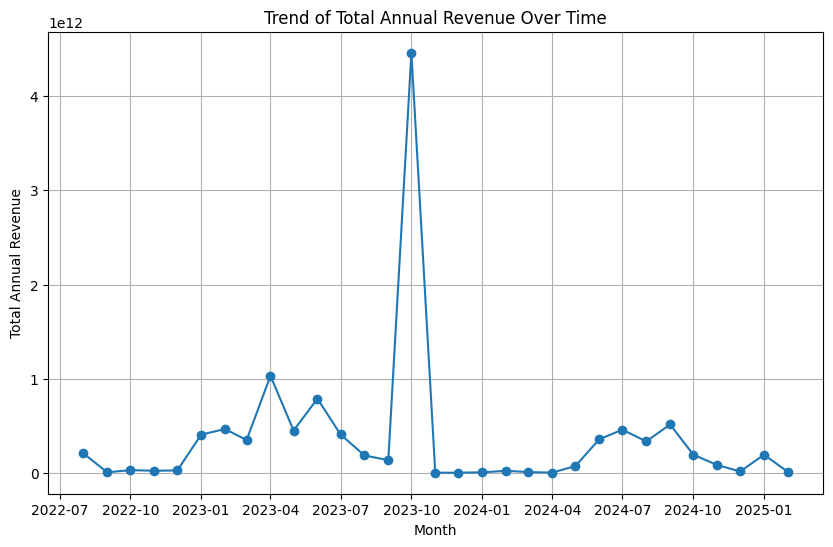

In [23]:
#  time-series trends: Aggregate 'Annual Revenue' by month
revenue_monthly = df.groupby('Create_Month')['Annual Revenue'].sum()
revenue_monthly.index = revenue_monthly.index.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(revenue_monthly.index, revenue_monthly.values, marker='o')
plt.xlabel("Month")
plt.ylabel("Total Annual Revenue")
plt.title("Trend of Total Annual Revenue Over Time")
plt.grid(True)
plt.show()

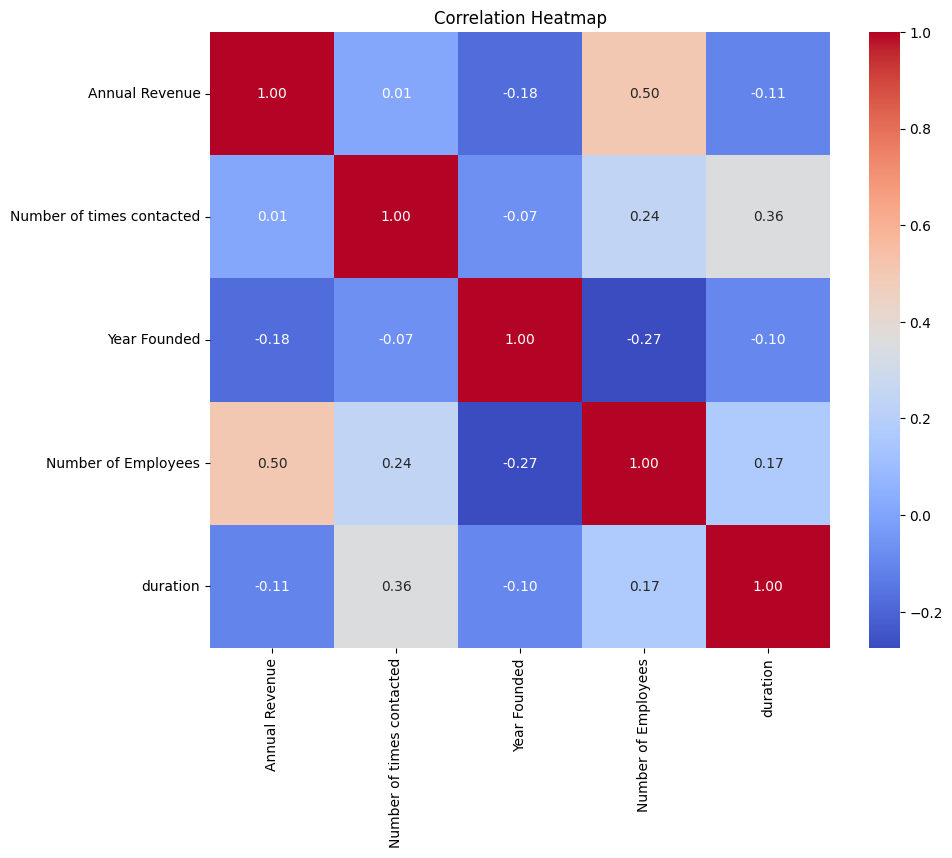

In [25]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

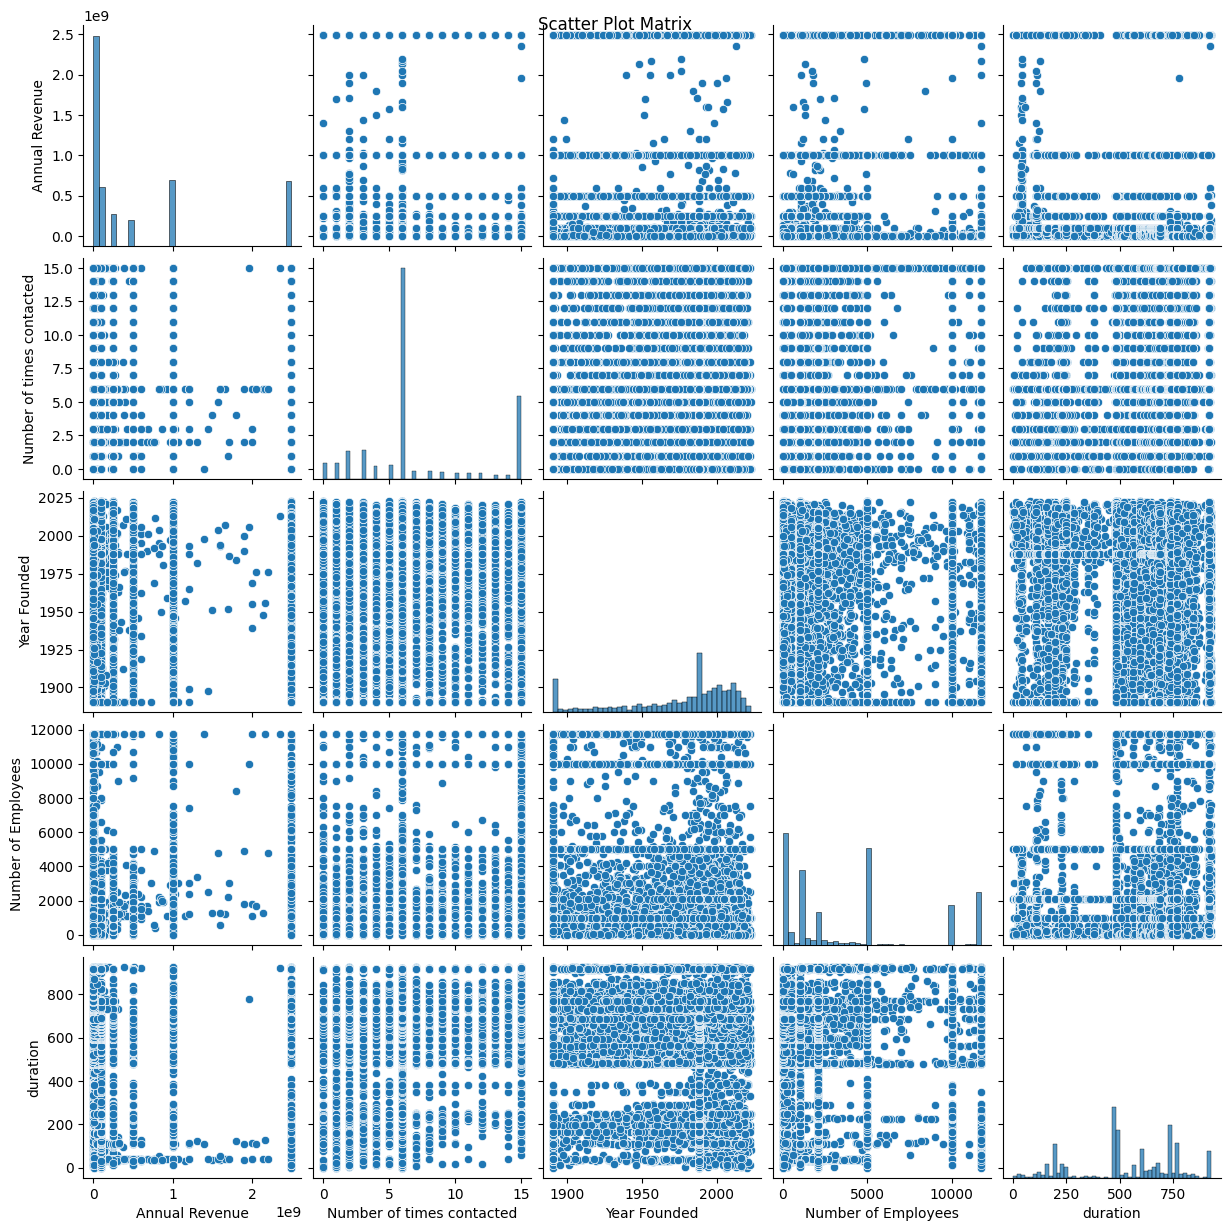

In [26]:
# scatter plots
sns.pairplot(df[num_columns])
plt.suptitle("Scatter Plot Matrix")
plt.show()